In [3]:
import numpy as np
import pandas as pa 
from matplotlib import pyplot as plt 
%matplotlib inline
from qutip import *
import tqdm

## Definitions

###  Matrices


In [4]:
sz_e = (sigmaz()-qeye(2))*0.5 #S_z matrix for electron subdomain
sz = tensor(sz_e, qeye(2)) # sz for 2x2 Hilbert space
iz = tensor(qeye(2), sigmaz()*0.5) # iz for 2x2 space
ix = tensor(qeye(2), sigmax()*0.5) # ix ---||-----
pi_2_g_e_x = gates.rotation(op=sigmax(), phi=np.pi/2.0, N=2, target=0) # pi/2 rotation of electron around x
pi_2_g_e_y = gates.rotation(op=sigmay(), phi=np.pi/2.0, N=2, target=0) # pi/2 rotation of electron around y
pi_g_e_x = gates.rotation(op=sigmax(), phi=np.pi, N=2,target=0) #pi rotation of electron around x

## Small angle rotations... Why??
pi_g_e_x_alpha = gates.rotation(op=sigmax(), phi=np.pi*0.1, N=2,target=0) 
pi_g_e_mx_alpha = gates.rotation(op=sigmax(), phi=-np.pi*0.1, N=2,target=0)
pi_g_e_y_alpha = gates.rotation(op=sigmay(), phi=np.pi*0.1, N=2,target=0)
pi_g_e_my_alpha = gates.rotation(op=sigmay(), phi=-np.pi*0.1, N=2,target=0)

### NV class

In [ ]:
class NV:
    def __init__(self, c13_zz,c13_zx,B):
        self.C13_zz = c13_zz
        self.C13_zx = c13_zx
        self.B = B
        self.init_h()
        
    def init_h(self):
        self.H = []
        gamma_e = 2.8 #MHz/G
        gamma_n = 10.7*1e-4 # MHz/G
        for i,zz in enumerate(self.C13_zz):
            self.H.append(
                iz*gamma_n*B*2*np.pi + 2*np.pi*sz*iz*zz +
                2*np.pi*sz*ix*self.C13_zx[i]
            )        
                
    def evolve_i(self, rho, seq, i):        
        rho1 = rho
        for s in seq:
            if isinstance(s, Qobj):
                rho1 = s*rho1*s.dag()
            elif isinstance(s, float):
                U = (self.H[i]*1j*s).expm()
                rho1 = U*rho1*U.dag()
            elif isinstance(s, dict):
                out = mesolve(rho0=rho1, H=self.H, c_ops=[tensor(sigmaz(),qeye(2))], tlist=np.linspace(0,s['T_c'], 10), 
                          options = Options(nsteps=1e5))
                return out.states[-1]                
        return rho1
    
    def experiment(self, seq, **kwargs):
        
        Pi = 1
        rho = tensor(fock_dm(2,0), qeye(2)*0.5)
        for i,zz in enumerate(self.C13_zz):
            
            rho1 = self.evolve_i(rho, seq(**kwargs),i)
            p0 = expect(sigmaz(), rho1.ptrace(0))
            Pi *= p0
        
        return Pi

    def hahn_echo(self,tau):
        seq = [
        pi_2_g_e_y, 
            tau, 
            pi_g_e_x,
            tau,
           pi_2_g_e_y.dag()
          ]
        return seq
        
    def xy4(self, tau):
        seq = [
        pi_2_g_e_y, 
            tau]
        
        for i in range(4):
            seq += [pi_g_e_x, tau]
                        
        
        seq += [pi_2_g_e_y.dag()]
        return seq
    
    def xy16(self, tau):
        seq = [
        pi_2_g_e_y, 
            tau]
        
        for i in range(8):
            seq += [pi_g_e_x, tau]
            seq += [pi_g_e_x, tau]
                        
        
        seq += [pi_2_g_e_y.dag()]
        return seq
    
    def xy_mxy16(self, tau):
        seq = [
        pi_2_g_e_y, 
            tau]
        
        for i in range(8):
            seq += [pi_g_e_x_alpha, tau]
            #seq += [pi_g_e_mx_alpha, tau]
            seq += [pi_g_e_y_alpha, tau]
            #seq += [pi_g_e_my_alpha, tau]
                        
        
        seq += [pi_2_g_e_y.dag()]
        return seq
         

### Random positioning of the carbons 

In [30]:
def generate_random_xyz(r=50, N = 10):
    x = np.random.uniform(-r,r,N)
    y = np.random.uniform(-r,r,N)
    z = np.random.uniform(-r,r,N)
    return np.array([x,y,z]).T
generate_random_xyz()

array([[ 30.6726596 , -11.40013108,   8.81984058],
       [ 48.32006081,  27.03073141,   1.86801923],
       [ 33.36738977, -30.30142285, -17.08305008],
       [-18.46205759, -35.63904031,  36.88181333],
       [-44.38640145,  21.6454779 ,  31.99063789],
       [ 41.33880944, -13.54351276, -11.42737997],
       [-22.66712998,  28.91263389, -36.42494358],
       [-34.79011526,  21.57590833,  31.37822345],
       [-45.1513848 , -27.97969218,  -5.78362785],
       [ 45.79143081,  27.29447892,  48.96561053]])

## Single test run 

### Generate a bath 

56.388888888888886


(array([[0., 1., 0., 0., 0., 0., 0., 0., 2., 7.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 9.]]),
 array([-0.6755877 , -0.60259581, -0.52960392, -0.45661203, -0.38362015,
        -0.31062826, -0.23763637, -0.16464448, -0.0916526 , -0.01866071,
         0.05433118]),
 <a list of 2 BarContainer objects>)

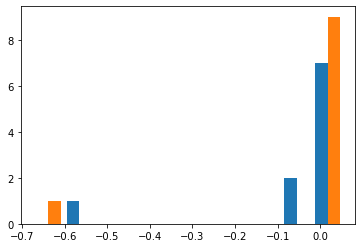

In [63]:

norm = lambda x: np.sqrt(np.sum(x*x))
factor_par  = lambda r, theta: (np.power(r, -3.0))*(3.0*np.power(np.cos(theta), 2.0)-1) # lambda eq for calculating parallel hyperfine coef
factor_perp = lambda r, theta: (np.power(r, -3.0))*(3.0*np.cos(theta)*np.sin(theta))    #                           perpendicular hyperfine coef

AparC_data   = []
AperpC_data  = []
dd13C = -19.885 #MHz/A^3

xyzC  = generate_random_xyz(r=15, N = 10)# Ängstrom

### calculate hyperfine coupling strength
                        # angle between z and vector from VSi to atom
rC = np.array([np.sqrt(np.sum(p*p)) for p in xyzC])    # the same as above for C
zzC = np.array([p[2] for p in xyzC])
thetaC = np.arccos(zzC/rC)

# calculation of the hyperfine coupling strength
AparC_data   = dd13C *factor_par (rC , thetaC )
AperpC_data  = dd13C *factor_perp(rC , thetaC )


C13_zz = np.array(AparC_data)
C13_zx = np.array(AperpC_data)
B = 60.9e-3 / 10.8 *1e4; print(B)
mynv = NV(B=B, c13_zx=C13_zz, c13_zz=C13_zx)
plt.hist([C13_zz, C13_zx])

### DD run

In [64]:
Pxy4 = []
Phe = []
Pxy16 = []
taus = np.linspace(0,50,100)
for tau in tqdm.tqdm_notebook(taus):
    Pxy4.append(mynv.experiment(seq=mynv.xy4,tau=tau))
    Pxy16.append(mynv.experiment(seq=mynv.xy16,tau=tau))
    Phe.append(mynv.experiment(seq=mynv.hahn_echo,tau=tau))  

/Users/vvv/opt/miniconda3/envs/qutip-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


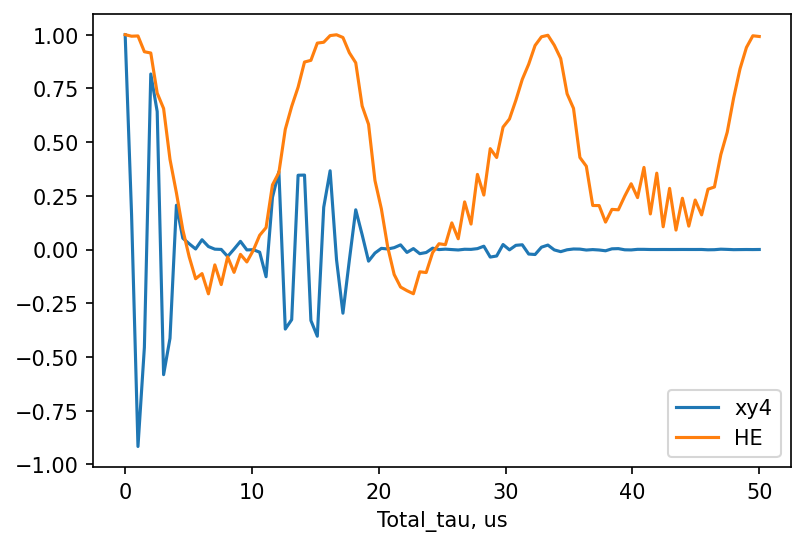

In [66]:
plt.figure(dpi=150)
#T2 = 100
plt.plot(taus, np.array(Pxy4), label = 'xy4')
plt.plot(taus, np.array(Pxy16), label = 'xy16')
plt.plot(taus, np.array(Phe), label = 'HE')
plt.xlabel('Total_tau, us')
plt.legend()
plt.savefig('he_xy4_xy16.png')

In [73]:
#np.savetxt(X = [taus,Phe,Pxy4], fname ='training/out0.txt')
#np.savetxt(X = [C13_zz, C13_zx], fname ='training/in0.txt')

## Generate a dataset for training 

In [75]:
for i in tqdm.tqdm_notebook(range(3000)):
    xyzC  = generate_random_xyz(r=15, N = 10)# Ängstrom

    ### calculate hyperfine coupling strength
                            # angle between z and vector from VSi to atom
    rC = np.array([np.sqrt(np.sum(p*p)) for p in xyzC])    # the same as above for C
    zzC = np.array([p[2] for p in xyzC])
    thetaC = np.arccos(zzC/rC)

    # calculation of the hyperfine coupling strength
    AparC_data   = dd13C *factor_par (rC , thetaC )
    AperpC_data  = dd13C *factor_perp(rC , thetaC )


    C13_zz = np.array(AparC_data)
    C13_zx = np.array(AperpC_data)
    B = 60.9e-3 / 10.8 *1e4;
    mynv = NV(B=B, c13_zx=C13_zz, c13_zz=C13_zx)
    
    
    Pxy4 = []
    Phe = []
    Pxy16 = []
    taus = np.linspace(0,50,100)
    for tau in taus:
        Pxy4.append(mynv.experiment(seq=mynv.xy4,tau=tau))
        #Pxy16.append(mynv.experiment(seq=mynv.xy16,tau=tau))
        Phe.append(mynv.experiment(seq=mynv.hahn_echo,tau=tau)) 
    np.savetxt(X = [taus,Phe,Pxy4], fname ='training/out'+str(i) +'.txt')
    np.savetxt(X = [C13_zz, C13_zx], fname ='training/in'+str(i) + '.txt')

/Users/vvv/opt/miniconda3/envs/qutip-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: 